# TCGA RNA-Seq RSEM normalized Collaborative Filtering

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

import pandas as pd
import numpy as np

In [2]:
path='~/data/tcga/'

## Preprocessing

### subset

In [3]:
df = pd.read_csv(path+'full.csv', sep=',', low_memory=False, index_col=[0]); df.head()

,LOC100130426,UBE2Q2P3,UBE2Q2P2,HMGB1P1,TIMM23,MOXD2,LOC155060,RNU12-2P,SSX9,LOC317712,...,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR,cancer
TCGA-2A-A8VL-01A-21R-A37L-07,0.0,4.375165,4.117130,6.338271,10.356474,0.0,8.299844,0.000000,0.0,0.0,...,8.150981,10.105178,5.251908,9.434774,11.169806,10.539810,8.980566,7.638647,0.000000,PRAD
TCGA-2A-A8VO-01A-11R-A37L-07,0.0,4.272068,3.798102,5.955957,9.754902,0.0,8.562890,0.000000,0.0,0.0,...,8.583033,9.826347,7.387885,9.562891,11.405313,9.738158,9.323495,8.188683,0.000000,PRAD
TCGA-2A-A8VT-01A-11R-A37L-07,0.0,5.611349,5.887579,6.561063,9.186661,0.0,9.511317,0.141302,0.0,0.0,...,9.226164,10.754531,5.475257,10.217726,10.583608,11.023235,10.423672,5.171103,-1.443791,PRAD
TCGA-2A-A8VV-01A-11R-A37L-07,0.0,4.441902,4.034550,6.756879,9.843444,0.0,7.889987,0.000000,0.0,0.0,...,8.718451,9.988854,6.010740,9.259221,11.578931,10.008104,10.034888,4.404563,0.000000,PRAD
TCGA-2A-A8VX-01A-11R-A37L-07,0.0,1.561937,3.110330,6.598782,9.701914,0.0,8.341960,0.000000,0.0,0.0,...,8.486776,9.957949,7.355339,9.468424,11.149634,9.709747,9.556007,3.765927,0.000000,PRAD


In [4]:
dupabbr = ['KIPAN', 'COADREAD', 'STES', 'GBMLGG']
df = df.loc[~df['cancer'].isin(dupabbr)]
sids = list(df.index)
df = df.assign(sid=sids)
df = df.loc[df.sid.str.split('-', expand=True).loc[:,3].str[0] != str(1)]

In [5]:
df = df.reset_index(); df = df.drop(columns=['index']); df.head()

,LOC100130426,UBE2Q2P3,UBE2Q2P2,HMGB1P1,TIMM23,MOXD2,LOC155060,RNU12-2P,SSX9,LOC317712,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR,cancer,sid
0,0.0,4.375165,4.117130,6.338271,10.356474,0.0,8.299844,0.000000,0.0,0.0,...,10.105178,5.251908,9.434774,11.169806,10.539810,8.980566,7.638647,0.000000,PRAD,TCGA-2A-A8VL-01A-21R-A37L-07
1,0.0,4.272068,3.798102,5.955957,9.754902,0.0,8.562890,0.000000,0.0,0.0,...,9.826347,7.387885,9.562891,11.405313,9.738158,9.323495,8.188683,0.000000,PRAD,TCGA-2A-A8VO-01A-11R-A37L-07
2,0.0,5.611349,5.887579,6.561063,9.186661,0.0,9.511317,0.141302,0.0,0.0,...,10.754531,5.475257,10.217726,10.583608,11.023235,10.423672,5.171103,-1.443791,PRAD,TCGA-2A-A8VT-01A-11R-A37L-07
3,0.0,4.441902,4.034550,6.756879,9.843444,0.0,7.889987,0.000000,0.0,0.0,...,9.988854,6.010740,9.259221,11.578931,10.008104,10.034888,4.404563,0.000000,PRAD,TCGA-2A-A8VV-01A-11R-A37L-07
4,0.0,1.561937,3.110330,6.598782,9.701914,0.0,8.341960,0.000000,0.0,0.0,...,9.957949,7.355339,9.468424,11.149634,9.709747,9.556007,3.765927,0.000000,PRAD,TCGA-2A-A8VX-01A-11R-A37L-07


In [6]:
len(df)

9544

### Melt

In [7]:
mdf = pd.melt(df, id_vars=['sid', 'cancer'], var_name='gene', value_name='log2exp'); mdf.head()

,sid,cancer,gene,log2exp
0,TCGA-2A-A8VL-01A-21R-A37L-07,PRAD,LOC100130426,0.0
1,TCGA-2A-A8VO-01A-11R-A37L-07,PRAD,LOC100130426,0.0
2,TCGA-2A-A8VT-01A-11R-A37L-07,PRAD,LOC100130426,0.0
3,TCGA-2A-A8VV-01A-11R-A37L-07,PRAD,LOC100130426,0.0
4,TCGA-2A-A8VX-01A-11R-A37L-07,PRAD,LOC100130426,0.0


## Collaborative filtering

In [8]:
val_idxs = get_cv_idxs(len(mdf))
wd=2e-4
n_factors = 50

In [9]:
cd = CollabFilterDataset.from_data_frame(path, mdf, 'sid', 'gene', 'log2exp')
learn = cd.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [10]:
learn.lr_find()

 41%|████      | 1002504/2449349 [54:53<1:19:13, 304.37it/s, loss=5.89]

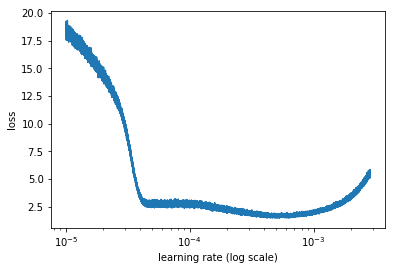

 41%|████      | 1002504/2449349 [55:10<1:19:37, 302.86it/s, loss=5.89]

In [11]:
learn.sched.plot(100)

In [10]:
lr=2e-5
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                           
    0      2.523097   2.418896  
    1      1.420943   1.545511                                           
 90%|████████▉ | 2203516/2449349 [2:07:56<14:16, 287.06it/s, loss=1.4]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    2      1.471677   1.436919                                         



[array([1.43692])]

In [5]:
preds = learn.predict()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


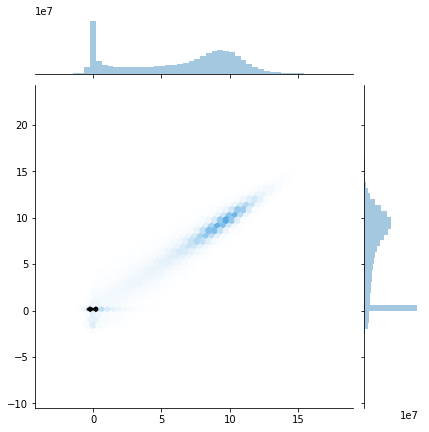

In [6]:
y=learn.data.val_y
# import seaborns as sns
sns.jointplot(preds, y, kind='hex', stat_func=None);

In [11]:
learn.save('tcga_collab_nonormal_nodup_new')

## Analyze results

#### shortcut to retrieve learner, model, df

In [3]:
df = pd.read_csv(path+'full.csv', sep=',', low_memory=False, index_col=[0], error_bad_lines=False); df.head()
dupabbr = ['KIPAN', 'COADREAD', 'STES', 'GBMLGG']
df = df.loc[~df['cancer'].isin(dupabbr)]
sids = list(df.index)
df = df.assign(sid=sids)
df = df.loc[df.sid.str.split('-', expand=True).loc[:,3].str[0] != str(1)]
df = df.reset_index(); df = df.drop(columns=['index']); df.head()
mdf = pd.melt(df, id_vars=['sid', 'cancer'], var_name='gene', value_name='log2exp'); mdf.head()
val_idxs = get_cv_idxs(len(mdf))
wd=2e-4
n_factors = 50
cd = CollabFilterDataset.from_data_frame(path, mdf, 'sid', 'gene', 'log2exp')
learn = cd.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)
learn.load('tcga_collab_nonormal_nodup_new')

In [12]:
genes = list(df.columns[:-2])
sids = list(df['sid'])
cancers = list(df['cancer'])
sid_ca = {s:c for s, c in zip(sids, cancers)}

### Embedding interpretation

### retrieve embeddings 

In [13]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(9544, 50)
  (i): Embedding(20531, 50)
  (ub): Embedding(9544, 1)
  (ib): Embedding(20531, 1)
)

#### gene embedding

In [14]:
geneidx = np.array([cd.item2idx[g] for g in genes])
gene_emb = to_np(m.i(V(geneidx)))
gene_emb.shape

(20531, 50)

In [15]:
gene_emb_df = pd.DataFrame(gene_emb, index=genes); gene_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
LOC100130426,0.050513,-0.117977,0.110022,-0.090094,-0.122309,-0.125740,0.087562,0.133232,0.111338,0.106445,...,0.055437,-0.053704,-0.128381,-0.118636,0.087714,-0.127137,-0.008893,-0.158745,-0.130260,0.077341
UBE2Q2P3,-0.182780,-0.050989,0.109183,-0.018587,-0.038582,-0.024687,-0.030002,-0.014056,0.038890,0.045570,...,0.106412,-0.093677,-0.240158,-0.055662,-0.005101,0.233076,0.222636,-0.034910,-0.113200,0.146629
UBE2Q2P2,-0.075158,-0.028146,0.039178,0.051488,-0.071518,0.005934,0.012412,-0.044538,0.042433,0.006491,...,0.082935,-0.111572,-0.129055,-0.021232,0.037064,0.222434,0.159524,-0.029696,-0.097363,0.086356
HMGB1P1,0.033421,-0.042931,-0.059557,-0.077010,0.029606,-0.037036,-0.027840,0.012707,-0.016803,0.055761,...,-0.133849,0.047887,-0.049316,-0.064157,-0.024767,0.009029,-0.024305,0.028480,0.039291,-0.048234
TIMM23,0.146740,0.074023,-0.045334,-0.031548,0.073077,-0.012814,-0.058427,-0.025028,-0.127059,-0.082129,...,-0.074233,0.099868,0.038468,-0.041373,-0.063770,-0.053583,-0.006198,0.057763,0.120407,-0.056460


In [16]:
gene_emb_df.to_csv(path+'gene_emb_CN_new.csv', sep=',')

In [ ]:
gene_emb_bias = to_np(m.ib(V(geneidx)))
gene_emb_bias_df = pd.DataFrame(gene_emb_bias, index=genes); gene_emb_bias_df.head()
gene_emb_bias_df.to_csv(path+'gene_emb_CN_new_bias.csv')

#### sample embedding 

In [17]:
sampleidx = np.array([cd.user2idx[sid] for sid in sids])
samp_emb = to_np(m.u(V(sampleidx)))
samp_emb.shape

(9544, 50)

In [18]:
samp_emb_df = pd.DataFrame(samp_emb, index=sids); samp_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
TCGA-2A-A8VL-01A-21R-A37L-07,-0.022406,0.089036,-0.029711,-0.103062,0.135620,0.116822,-0.255778,-0.269957,-0.070858,-0.110527,...,0.000209,0.203793,0.341037,0.276610,-0.171037,0.370404,-0.052283,0.208842,0.200567,-0.091652
TCGA-2A-A8VO-01A-11R-A37L-07,0.019864,0.079429,-0.026811,-0.166263,0.115723,0.238744,-0.228593,-0.179147,-0.113323,-0.083262,...,-0.000370,0.198950,0.328061,0.228008,-0.178069,0.284119,-0.116576,0.183606,0.143944,-0.056440
TCGA-2A-A8VT-01A-11R-A37L-07,-0.135329,0.124612,-0.044571,-0.062118,0.116239,0.166197,-0.279448,-0.256112,-0.123666,-0.044595,...,0.022338,0.171933,0.119638,0.152092,-0.195205,0.431459,-0.041833,0.184240,0.153330,-0.105726
TCGA-2A-A8VV-01A-11R-A37L-07,-0.024081,0.113953,-0.072417,-0.129229,0.146727,0.166847,-0.289360,-0.219512,-0.101056,-0.165783,...,0.014345,0.226505,0.252545,0.273411,-0.136340,0.415646,-0.125109,0.179495,0.215235,-0.061867
TCGA-2A-A8VX-01A-11R-A37L-07,0.149962,0.127858,-0.042393,-0.122737,0.116584,0.200117,-0.241627,-0.108605,-0.140876,-0.134693,...,-0.017443,0.205087,0.246886,0.225850,-0.173025,0.413153,-0.108838,0.226842,0.183256,-0.127880


In [19]:
samp_emb_df.to_csv(path+'samp_emb_CN_new.csv', sep=',')

In [20]:
samp_emb_bias = to_np(m.ub(V(sampleidx)))
samp_emb_bias_df = pd.DataFrame(samp_emb_bias, index=sids); samp_emb_bias_df.head()
samp_emb_bias_df.to_csv(path+'samp_emb_CN_new_bias.csv')